In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy as sp
import os,csv
import statsmodels.api as sm
from scipy import interpolate
import sys
sys.path.append("..")

# === Matplotlib ===
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams


# === Import Maksim's functions === 
# Module in the same directory MD_Capacitance.py
import MD_potential
from MD_potential import *
import MD_capacitance
from MD_capacitance import *

# === Logging ===
import logging
logging.basicConfig()
log=logging.getLogger('ipynb')
log.setLevel(logging.DEBUG)
log.info('logging initialized')

# === Import defined parameters for plotting ===
# Module in the same directory graph_parameters.py
import graph_parameters
from graph_parameters import *
#from graph_parameters import savitzky_golay


# === Import constants ===
# Module in the same directory constants.py
import constants

/home/prace/opt/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
INFO:ipynb:logging initialized
INFO:ipynb:logging initialized


/home/prace/opt/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


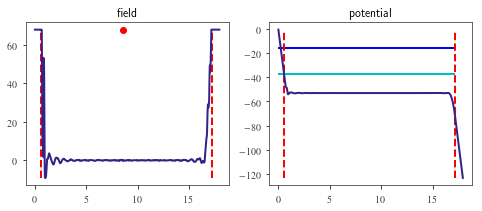

In [2]:
chsim1 = ChgSimulation('/data/Julia/AuBMImPF6/Experiments/A2/BMImPF6/450/a/60.00', chg_name='charge.xvg',
                       pot_name='potential_mod.xvg', field_name='field_mod.xvg', replicas=['1'], walls=[0.551, 17.225])#, set_chg=True)

chsim1.plot() #xlim=(15,18)

# Load potentials

MD_potential.py:313: RuntimeWarning: invalid value encountered in divide
  return np.abs(.6745*(vals - np.median(vals))/mad)


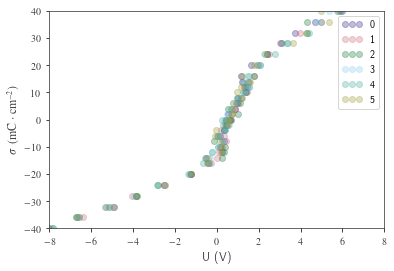

In [3]:
# directory containing base directories for simulations with different electrode surface charges
base_path = '/data/Julia/AuBMImPF6/Experiments/A2/BMImPF6/450/a'

# surface charges to analyze
surf_chgs = [dirs for dirs in os.listdir(base_path) 
              if os.path.isdir(os.path.join(base_path, dirs)) and '.' in dirs]
surf_chgs = sorted(surf_chgs, key=float)

replicas = ['0','1','2','3','4','5']              # which replicas to analyze for each charge
for r in replicas:
    chg_name='charge.xvg'                   # the name of text file containign values of charge depending on z
    generic_data_path = base_path + '/{surf_chg}'  # should reflect directory structure
    # optional
    pot_name = 'potential_mod.xvg'              # the name of text file containign values of potential depending on z
    field_name = 'field_mod.xvg'                # the name of text file containign values of field depending on z
    walls=None
    #A2 0.551 17.225 0.072
    walls = (0.551+0.072, 17.225-0.072)         #0.072 is a half space between Au-Au layers
    set_chg = False  # x-y dimensions in nm
    debug = True  # extra printing and plotting
    if debug:
        log.setLevel(level=logging.DEBUG)

    simulations = []
    for surf_chg in surf_chgs:
        p = generic_data_path.format(surf_chg=surf_chg)
        try:
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=r, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, set_chg=set_chg)
            simulations.append(chsim)
            #print surf_chg
            #chsim.plot()
        except IOError:
            log.info('Simulations for surf_chg = {} were not found!, skipping!'.format(surf_chg))
        except Exception as e:
            log.exception(e)
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=replicas, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, log=log)
    pots = compute_potentials(simulations, exclude_outliers=True)
    plt.plot(pots[:,0], pots[:,1], 'o', alpha=0.3, label=str(r))
plt.xlim(-8,8)
plt.ylim(-40,40)
plt.xlabel('U (V)')
plt.ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
plt.legend(loc='best')

Check that potential looks ok and that there are no outliers

# Capacitance calculations

### Smoothing pot/chg

Capacitance maximum: 17.7382465409
Corresponding charge: -0.1001001001
Corresponding potential: 0.51479863453


(0, 20)

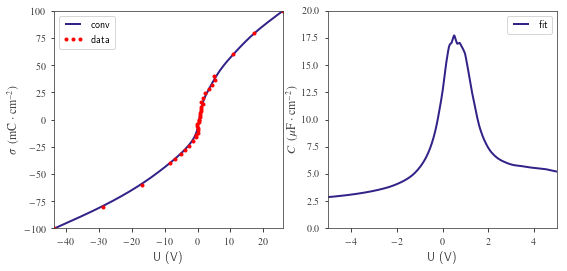

In [4]:
fig, (ax1,ax2) =plot_cap(compute_potentials(simulations, rel_pos=0.0), fine_ws=161)
ax2.set_xlim(-5,5)
ax2.set_ylim(0,20)

Capacitance maximum: 17.7382465409
Corresponding charge: -0.1001001001
Corresponding potential: 0.51479863453


(-2, 2)

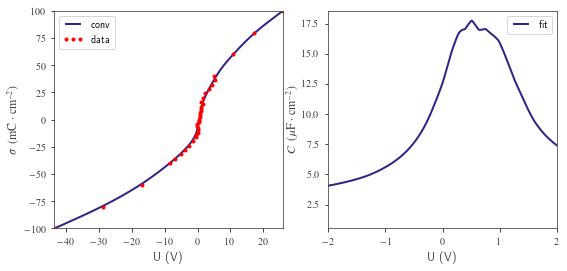

In [5]:
fig, (ax1, ax2) = plot_cap(compute_potentials(simulations, rel_pos=.0), fine_ws=161)
ax2.set_xlim(-2, 2)
#ax2.set_ylim(0,100)


In [6]:
chg_pot_cap = compute_cap(compute_potentials(simulations, rel_pos=.087),itp_points=1000, w='hamming', 
                          fine_ws=61, coarse_ws=151, chg_left=-20, chg_right=20)

np.savetxt('/home/prace/Bi_emimI_chg_pot_cap.txt', chg_pot_cap)

In [19]:
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

In [20]:
def func(**kwargs):
    plot_cap(compute_potentials(**kwargs))

interactive(func, simulations=fixed(simulations), rel_pos=(-.5, .5, .01))


interactive(children=(FloatSlider(value=0.0, description=u'rel_pos', max=0.5, min=-0.5, step=0.01), Output()), _dom_classes=('widget-interact',))

# Fit function

### fitting cation

In [21]:
U0 = .15        # V
U_max_c = -1.27877117e+01
theta_max_c = 40


def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]


def fit_c(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains: U_max_c (V), gamma_c, a0_c
    """
    gamma_c, a0_c = x
    u = (U - U0)/U_max_c
    sigma_fit_c = sigma_fit(u, theta_max_c, gamma_c, a0_c)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_c, gamma_c, a0_c)+theta_max_c))+1)
    return np.sum(np.abs(sigma-sigma_fit_c)**(2)*inv_dist_from_kappa)


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_c_fit = chg_itp[chg_itp < -30]
U_c_fit = conv_pot[chg_itp < -30]


# initial guess
# gamma, a0
x0 = [  2.02, 0.62]

res = sp.optimize.minimize(fit_c, x0, args=(sigma_c_fit, U_c_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
#x  = res.x
x = res.x

u = (U_c_fit-U0)/U_max_c
plt.plot(U_c_fit, sigma_c_fit,'-o', label='data')
plt.plot(U_c_fit, sigma_fit(u, theta_max_c, x[0], x[1]), '-', label='fit')
plt.plot(U_c_fit, sigma_fit(u, theta_max_c, x0[0], x0[1]), '--', label='fit0')

plt.xlabel('sigma microC/cm2')
plt.ylabel('U V')
plt.legend(loc='best')

NameError: name 'chg_itp' is not defined

In [ ]:
U0 = .15          # V
U_max_a =  8.64749511e+00
theta_max_a = -16  # microC/cm^2

def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]


def fit_a(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains:  gamma_a, a0_a
    """
    gamma_a, a0_a = x
    u = (U - U0)/U_max_a
    sigma_fit_a = sigma_fit(u, theta_max_a, gamma_a, a0_a)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_a, gamma_a, a0_a)+theta_max_a))+1)
    return np.sum(np.abs(sigma-sigma_fit_a)**(2)*inv_dist_from_kappa)


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_a_fit = chg_itp[chg_itp > 10]
U_a_fit = pot_itp[chg_itp > 10]


# initial guess
# gamma, a0
x0 = [  2, 0.7]

res = sp.optimize.minimize(fit_a, x0, args=(sigma_a_fit, U_a_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
#x  = res.x
x = res.x

u = (U_a_fit-U0)/U_max_a
plt.plot(U_a_fit, sigma_a_fit,'-o', label='data')
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, x[0], x[1]), '-', label='fit')
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, x0[0], x0[1]), '--', label='fit0')

plt.xlabel('sigma microC/cm2')
plt.ylabel('U V')
plt.legend(loc='best')

In [ ]:
def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]



# data
U0 = .15          # V
U_max_a =  8.64749511e+00
U_max_c =  1.27877117e+01
theta_max_a = -16  # microC/cm^2
theta_max_c = 40#60#  # microC/cm^2

# fitted values
gamma_c = 1.90891538
a0_c = 0.61969294
gamma_a = 43.52760518
a0_a = 0.71859516

# individual capacitances
#U_fit = np.linspace(-80, 40, num=1000)
U_fit, dU = np.linspace(-80, 80, num=1000, retstep=True)
u_a = (U_fit-U0)/U_max_a
u_c = (U_fit-U0)/U_max_c

sigma_a = sigma_fit(u_a, theta_max_a, gamma_a, a0_a)
sigma_c = -sigma_fit(u_c, theta_max_c, gamma_c, a0_c)
C_a = np.gradient(sigma_a, dU)
C_c = np.gradient(sigma_c, dU)

# combination of capacitances
gamma_ac = (max(gamma_c, gamma_a)/min(gamma_c, gamma_a))**(1./2)
C_h = 0.5*(C_a+C_c)+ 0.5*(np.tanh(gamma_ac*u_a)*C_a-np.tanh(gamma_ac*u_c)*C_c)

# smoothing
window = sp.signal.gaussian(400, 20)
# convolve the arrays
sC_h = sp.signal.convolve(C_h, window/window.sum(), mode='same')

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(7,3.25))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(chg_pot_cap[:,1],chg_pot_cap[:,0],'--',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_xlim(-60,60)
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)

#ax2.plot(U_fit, C_a, label='C-a',alpha=.3)
#ax2.plot(U_fit, C_c, label='C-c', alpha=.3)
ax2.plot(U_fit, C_h, label='C', color=color_wheel[3])
ax2.plot(U_fit, sC_h, label='C sm', color=color_wheel[5])
ax2.plot(conv_pot,chg_pot_cap[:,2], '--',lw=5,  label='data',color=color_wheel[2])

ax2.set_xlim(-15, 15)
ax2.set_xlabel('$U$ $V$')
ax2.set_ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
ax2.locator_params(axis = 'x',nbins=5)

ax2.legend(loc='best', fontsize=11)

fig.tight_layout()
#fig.savefig('../gfx/estimated_cap.png',dpi=300)

In [ ]:
fig, (ax1) = plt.subplots(ncols=1,figsize=(7,7))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(gromacs_data[:,0],gromacs_data[:,1],'o',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_xlim(-40,40)
ax1.set_ylim(-130,130)
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)

interp = sp.interpolate.InterpolatedUnivariateSpline(U_fit, sC_h, k=1)
x_interp = np.linspace(-20, 20, num=1000)
interp = interp.antiderivative()
sigma_s = interp(x_interp) 
ax1.plot(x_interp, sigma_s - 130)

In [ ]:

plt.figure(figsize=(3.25,3.25))
plt.xlim(-10, 10)
plt.xlabel('$U$ $V$')
plt.ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
#plt.plot(U_fit, C_h, '-', label='C-h',alpha=.1,color='k')
#plt.plot(conv_pot,chg_pot_cap[:,2],'-' , label='fit',alpha=.1,color='k')

import matplotlib.colors as colors
import matplotlib.cm as cmx
values = range(10)
cmap = plt.cm.cool 
line_colors = cmap(np.linspace(0,1,5))

smoothing_factor = [0.5, 1,  2.5, 5, 10]
for i in range(len(smoothing_factor)):
    # smoothing
    window = sp.signal.gaussian(400, smoothing_factor[i])
    # convolve the arrays
    sC_h = sp.signal.convolve(C_h, window/window.sum(), mode='same')
    plt.plot(U_fit, sC_h,label='sC-h'+str(smoothing_factor), alpha=1, color=line_colors[i])


# plt.plot(U_fit, sigma_a, label='A')
# plt.plot(U_fit, sigma_c, label='C')
# plt.xlabel('reduced V')
# plt.ylabel('sigma microC/cm2')
# plt.legend(loc='best')

# plt.show()
#plt.plot(U_fit, C_a, label='C-a')
#plt.plot(U_fit, C_c, label='C-c')
plt.tight_layout()
#plt.savefig('../gfx/smoothing_factor.png',dpi=300)

In [ ]:
# data
U0 = .17          # V
U_max_a =  2.92238593e+01
U_max_c =  1.48911278e+01#-2.64117427e+01#
theta_max_a = -98  # microC/cm^2
theta_max_c = 40#60#  # microC/cm^2

# fitted values
gamma_c = 1.6230877
a0_c = 0.68479482
gamma_a = 162.01022641
a0_a = 0.71178643


u = np.linspace(-2, 2,1000)
plt.plot(u*U_max_a, a0_a + (1-a0_a)*np.exp(-gamma_a*u**2))
plt.xlim(-10,10)

In [ ]:
# data
U0 = .17          # V
U_max_a =  2.92238593e+01
U_max_c =  1.48911278e+01#-2.64117427e+01#
theta_max_a = -98  # microC/cm^2
theta_max_c = 40#60#  # microC/cm^2

# fitted values
gamma_c = 1.6230877
a0_c = 0.68479482
gamma_a = 162.01022641
a0_a = 0.71178643


u = np.linspace(-2, 2,1000)
plt.plot(u*U_max_c, a0_c + (1-a0_c)*np.exp(-gamma_c*u**2))
#plt.xlim(-10,10)

# Calculating a

In [ ]:
sigma_r = np.r_[(chg_pot_cap[:,0]/theta_max_c)[chg_pot_cap[:,0]<=0], -(chg_pot_cap[:,0]/theta_max_a)[chg_pot_cap[:,0]>0]]
u_r = np.r_[(chg_pot_cap[:,1]/U_max_c)[chg_pot_cap[:,0]<=0], (chg_pot_cap[:,1]/U_max_a)[chg_pot_cap[:,0]>0]]

In [ ]:
sigma_r = (chg_pot_cap[:,0]/theta_max_c)[chg_pot_cap[:,0]<=0]
u_r  = (chg_pot_cap[:,1]/U_max_c)[chg_pot_cap[:,0]<=0]

# plt.plot(u_r, sigma_r)
# plt.show()
plt.plot(u_r, a0_c + (1-a0_c)*np.exp(-gamma_c*-u_r*2))

plt.plot(u_r, np.log(-sigma_r)/np.log(-u_r))
# plt.xlim(-1.3,0)
plt.ylim(0,1)

In [ ]:
sigma_r = -(chg_pot_cap[:,0]/theta_max_a)[chg_pot_cap[:,0]>0]
u_r  = (chg_pot_cap[:,1]/U_max_a)[chg_pot_cap[:,0]>0]

plt.plot(u_r, sigma_r)
plt.show()
plt.plot(u_r, a0_a + (1-a0_a)*np.exp(-gamma_a*u_r/80),)

plt.plot(u_r, np.log(sigma_r)/np.log(u_r),'--')
plt.ylim(0,1)
plt.xlim(0,1.3)

In [ ]:
pwd

In [ ]:
# directory containing base directories for simulations with different electrode surface charges
base_path = '/data/Julia/AuBmimPF6/Experiments/A3/BMImPF6/450/a'

# surface charges to analyze
surf_chgs = [dirs for dirs in os.listdir(base_path) 
              if os.path.isdir(os.path.join(base_path, dirs)) and '.' in dirs]
surf_chgs = sorted(surf_chgs, key=float)


replicas = ['0','1','2','3','4']              # which replicas to analyze for each charge
for r in replicas:
    chg_name='charge.xvg'                   # the name of text file containign values of charge depending on z
    generic_data_path = base_path + '/{surf_chg}'  # should reflect directory structure
    # optional
    pot_name = 'potential_mod.xvg'              # the name of text file containign values of potential depending on z
    field_name = 'field_mod.xvg'                # the name of text file containign values of field depending on z
    walls=None
    #A2 0.551 17.225 0.072
    #A3 0.825 17.499 0.072
    walls = (0.825, 17.499)         #0.072 is a half space between Au-Au layers
    set_chg = False  # x-y dimensions in nm
    debug = True  # extra printing and plotting
    if debug:
        log.setLevel(level=logging.DEBUG)

    simulations = []
    for surf_chg in surf_chgs:
        p = generic_data_path.format(surf_chg=surf_chg)
        try:
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=r, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, set_chg=set_chg)
            simulations.append(chsim)

            #print surf_chg
            #chsim.plot()
        except IOError:
            log.info('Simulations for surf_chg = {} were not found!, skipping!'.format(surf_chg))
        except Exception as e:
            log.exception(e)
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=replicas, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, log=log)
    pots0 = compute_potentials(simulations, exclude_outliers=True)
    #pots1 = compute_potentials(simulations, -.1)
    #pots2 = compute_potentials(simulations, .1)
    plt.plot(pots0[:,0], pots0[:,1],'o', alpha=.3, label=r)
plt.legend()


In [ ]:
log.setLevel(logging.INFO)

pots0 = compute_potentials(simulations, exclude_outliers=True)
#pots1 = compute_potentials(simulations, -.1)
#pots2 = compute_potentials(simulations, .1)

plt.plot(pots0[:,0], pots0[:,1],'.')
#plt.plot(pots1[:,0], pots1[:,1],'o')
#plt.plot(pots2[:,0], pots2[:,1],'o')
plt.xlabel('U (V)')
plt.ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
